In [1]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
!pip install -U "tensorflow>=2.10.0"
!pip install opencv-python
!pip install -q git+https://github.com/tensorflow/docs
!pip install imageio
!pip install mlxtend

In [2]:
import os
os.environ['PYTHONHASHSEED']='0'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from sklearn.preprocessing import LabelEncoder

import cv2 # process video files

import imageio
from tensorflow_docs.vis import embed #for embedding data in a Jupyter notebook
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import math

In [3]:
def reset_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)
    tf.keras.utils.set_random_seed(seed_value)
    tf.config.experimental.enable_op_determinism()

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
# folder path that you store the video file and csv file
dataset_file_path = "C:/Users/hilma/Downloads/"

dataset_filepath = dataset_file_path+"input_data/input_data_new.csv"
df = pd.read_csv(dataset_filepath)

In [5]:
def convert_time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df["start_time_seconds"]=df["Start_Time"].apply(convert_time_to_seconds)
df["end_time_seconds"]=df["End_Time"].apply(convert_time_to_seconds)
class_list = df.Movement_Name.unique()

In [6]:
video_list = df.File_Path.unique()

In [7]:
video_list

array(['input_data/2.mp4', 'input_data/3.mp4', 'input_data/4.mp4',
       'input_data/5.mp4', 'input_data/8.mp4', 'input_data/10.mp4',
       'input_data/13.mp4', 'input_data/14.mp4', 'input_data/15.mp4',
       'input_data/16.mp4', 'input_data/18.mp4', 'input_data/19.mp4',
       'input_data/20.mp4', 'input_data/21.mp4', 'input_data/22.mp4',
       'input_data/24.mp4', 'input_data/25.mp4', 'input_data/26.mp4',
       'input_data/27.mp4', 'input_data/28.mp4', 'input_data/29.mp4',
       'input_data/30.mp4', 'input_data/31.mp4', 'input_data/32.mp4',
       'input_data/33.mp4', 'input_data/34.mp4', 'input_data/35.mp4',
       'final_exam/input/35.mp4'], dtype=object)

In [8]:
import random

# Set a specific seed value (for example, 42)
random.seed(42)

train_split_ratio = 0.8

random.shuffle(video_list)

split_idx = int(len(video_list) * train_split_ratio)

# Split data into train and test sets
train_videos_list_init = video_list[:split_idx]
test_videos_list = video_list[split_idx:]


train_validate_ratio = 0.75
random.shuffle(train_videos_list_init)

split_idx = int(len(train_videos_list_init) * train_validate_ratio)

train_videos_list= train_videos_list_init[:split_idx]
validate_videos_list = train_videos_list_init[split_idx:]



In [9]:
train_videos_list

array(['input_data/4.mp4', 'input_data/19.mp4', 'input_data/35.mp4',
       'input_data/20.mp4', 'final_exam/input/35.mp4', 'input_data/3.mp4',
       'input_data/34.mp4', 'input_data/16.mp4', 'input_data/10.mp4',
       'input_data/21.mp4', 'input_data/25.mp4', 'input_data/31.mp4',
       'input_data/28.mp4', 'input_data/30.mp4', 'input_data/18.mp4',
       'input_data/8.mp4'], dtype=object)

In [10]:
validate_videos_list

array(['input_data/33.mp4', 'input_data/24.mp4', 'input_data/13.mp4',
       'input_data/27.mp4', 'input_data/22.mp4', 'input_data/26.mp4'],
      dtype=object)

In [11]:
test_videos_list

array(['input_data/14.mp4', 'input_data/15.mp4', 'input_data/32.mp4',
       'input_data/2.mp4', 'input_data/5.mp4', 'input_data/29.mp4'],
      dtype=object)

In [12]:
#Extract frame from video
def extract_frame(path,start_time,end_time):
  frame_list = []
  SEQUENCE_LENGTH = 24

  # Open the video file for reading
  video_reader = cv2.VideoCapture(path)

  # Get the frames per second (fps), start_frame, and end_frame for the specified video duration
  fps = int(video_reader.get(cv2.CAP_PROP_FPS))
  frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  start_frame = int(start_time*fps)
  end_frame = int(end_time*fps)
  interval_frame = end_frame - start_frame

  #calculate the skip frame number formula total duration of interval frame / sequence length
  skip_frame_window = max(interval_frame/SEQUENCE_LENGTH,1)

  # Get the height and width of the video frames
  height = video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width = video_reader.get(cv2.CAP_PROP_FRAME_WIDTH)
  print(f'fps:{fps}, frame_cnt:{frame_count} interval_frame:{interval_frame}, height:{height}, width:{width}, start_frame:{start_frame},end_frame:{end_frame},skip:{skip_frame_window}')


  # Set the video reader to the start frame
  video_reader.set(cv2.CAP_PROP_POS_FRAMES,start_frame)
  current_frame = start_frame

  # Iterate through frames in the specified interval
  while video_reader.isOpened() and math.ceil(current_frame) < end_frame:
    ret, frame = video_reader.read()
    if not ret:
      break

    # Convert the frame from BGR to RGB
    frame_rgb_opencv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Resize the frame to a specific size (720x1280)
    resized_frame = cv2.resize(frame_rgb_opencv,(150,150))
      
    #normalize data to [0,1]
    frame = tf.image.convert_image_dtype(resized_frame, tf.float32)

    #brightness_increase = 70/255
    #brightened_frame = np.where((1 - frame) < brightness_increase, 1, frame + brightness_increase)
      
    # Append the resized frame to the frame_list
    frame_list.append(frame)

    # Set the video reader to the next frame position
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, int(current_frame + skip_frame_window) )

    # Increment the current_frame by skip_frame_window
    current_frame += skip_frame_window


  # Release the video reader and close any remaining OpenCV windows
  video_reader.release()
  cv2.destroyAllWindows()
    
  # Return the list of extracted frames
  return frame_list;

In [13]:
X_train = [] #Save the frame
Y_train = [] #Save the label
X_validate = [] #Save the frame
Y_validate = [] #Save the label
X_test = [] #Save the frame
Y_test = [] #Save the label

for index,row in df.iterrows():
    start_time = row["start_time_seconds"]
    end_time = row["end_time_seconds"]
    path = dataset_file_path + row["File_Path"] # Get the vidoe file path
    label = row["Movement_Name"] # Get the Movement lable
    video_path = row["File_Path"]
   
    if video_path in train_videos_list:
        Y_train.append(np.where(class_list == label)[0][0])
        frame_list = extract_frame(path,start_time,end_time)
        X_train.append(np.asarray(frame_list))
    elif video_path in validate_videos_list:
        Y_validate.append(np.where(class_list == label)[0][0])
        frame_list = extract_frame(path,start_time,end_time)
        X_validate.append(np.asarray(frame_list))
    else:
        Y_test.append(np.where(class_list == label)[0][0])
        frame_list = extract_frame(path,start_time,end_time)
        X_test.append(np.asarray(frame_list))

#encode the label by using one-hot encoded
one_hot_encoded_labels_train = to_categorical(Y_train)
Y_train = one_hot_encoded_labels_train

one_hot_encoded_labels_validate = to_categorical(Y_validate)
Y_validate = one_hot_encoded_labels_validate

one_hot_encoded_labels_test = to_categorical(Y_test)
Y_test = one_hot_encoded_labels_test
    

fps:30, frame_cnt:1538 interval_frame:150, height:360.0, width:204.0, start_frame:330,end_frame:480,skip:6.25
fps:30, frame_cnt:1538 interval_frame:120, height:360.0, width:204.0, start_frame:570,end_frame:690,skip:5.0
fps:30, frame_cnt:1538 interval_frame:150, height:360.0, width:204.0, start_frame:840,end_frame:990,skip:6.25
fps:15, frame_cnt:931 interval_frame:75, height:480.0, width:640.0, start_frame:330,end_frame:405,skip:3.125
fps:30, frame_cnt:5991 interval_frame:210, height:720.0, width:1280.0, start_frame:1950,end_frame:2160,skip:8.75
fps:30, frame_cnt:5991 interval_frame:240, height:720.0, width:1280.0, start_frame:3960,end_frame:4200,skip:10.0
fps:15, frame_cnt:526 interval_frame:180, height:720.0, width:1280.0, start_frame:30,end_frame:210,skip:7.5
fps:23, frame_cnt:6078 interval_frame:69, height:240.0, width:320.0, start_frame:414,end_frame:483,skip:2.875
fps:23, frame_cnt:6078 interval_frame:92, height:240.0, width:320.0, start_frame:1081,end_frame:1173,skip:3.8333333333

In [14]:
def to_gif(images):
  converted_images = np.clip(images*255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=24)
  return embed.embed_file('./animation.gif')


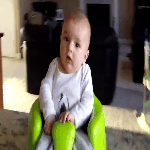

In [15]:
to_gif(X_train[1])

In [16]:
len(X_train)

32

In [17]:
def data_augmentation_flip_bright(X_train,Y_train):
    X_train_aug = []
    Y_train_aug = []

    for frame_list in X_train:
        frame_list_aug = []
        for frame in frame_list:
            flipped_frame = cv2.flip(frame,1)
            
            brightness_increase = 75/255
            brightened_frame = np.where((1 - flipped_frame) < brightness_increase, 1, flipped_frame + brightness_increase)
            
            frame_list_aug.append(flipped_frame)
        X_train_aug.append(np.asarray(frame_list_aug))

    for label in Y_train:
        Y_train_aug.append(label)
        
    return X_train_aug,Y_train_aug


In [18]:
def data_augmentation_rotate_contrast(X_train,Y_train):
    X_train_aug = []
    Y_train_aug = []

    for frame_list in X_train:
        frame_list_aug = []
        for frame in frame_list:
            # Define the rotation angle (in degrees)
            angle = 180  # Example rotation angle

            # Get image dimensions for rotation
            height, width = frame.shape[:2]
            
            # Calculate the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

            # Perform the rotation
            rotated_frame = cv2.warpAffine(frame, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)


            alpha = 1.5  # Contrast control (1.0 means no change)
            adjusted_frame = cv2.multiply(rotated_frame, np.array([alpha])) 

            frame_list_aug.append(adjusted_frame)
        X_train_aug.append(np.asarray(frame_list_aug))

    for label in Y_train:
        Y_train_aug.append(label)
        
    return X_train_aug,Y_train_aug

In [19]:
def data_augmentation_grayscale(X_train,Y_train):
    X_train_aug = []
    Y_train_aug = []

    for frame_list in X_train:
        frame_list_aug = []
        for frame in frame_list:
            gray_img = cv2.cvtColor((frame * 255).astype(np.uint8),cv2.COLOR_RGB2GRAY)
            normalized_frame = gray_img / 255.0

             # Expand dimensions to match the required channel size (e.g., 3 for RGB)
            expanded_frame = np.expand_dims(normalized_frame, axis=-1)  # Add a channel dimension
            
            # Duplicate the grayscale channel to match the number of channels in the original RGB frames
            stacked_frame = np.concatenate([expanded_frame] * 3, axis=-1)  # Repeat grayscale channel 3 times
            
            frame_list_aug.append(stacked_frame)
            
        X_train_aug.append(np.asarray(frame_list_aug))

    for label in Y_train:
        Y_train_aug.append(label)
        
    return X_train_aug,Y_train_aug

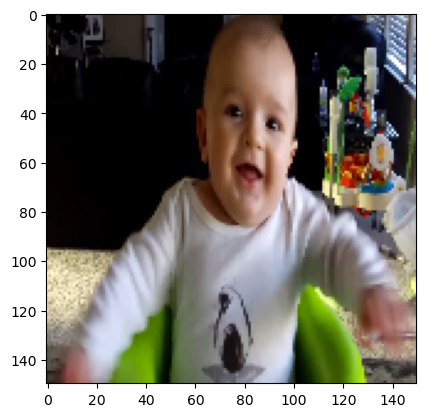

In [20]:
ori_images = np.clip(X_train[2][1]*255, 0, 255).astype(np.uint8)
plt.imshow(ori_images)

In [21]:
X_train_aug_1,Y_train_aug_1 = data_augmentation_flip_bright(X_train,Y_train)

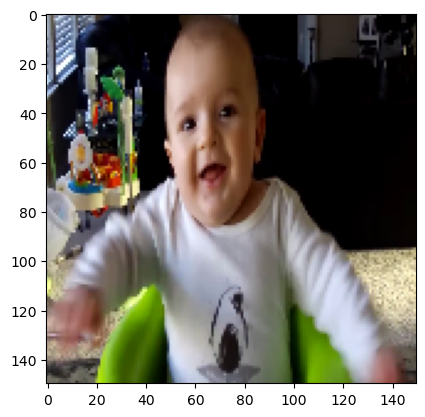

In [22]:
converted_images = np.clip(X_train_aug_1[2][1]*255, 0, 255).astype(np.uint8)
plt.imshow(converted_images)

In [23]:
X_train_aug_2,Y_train_aug_2 = data_augmentation_rotate_contrast(X_train,Y_train)

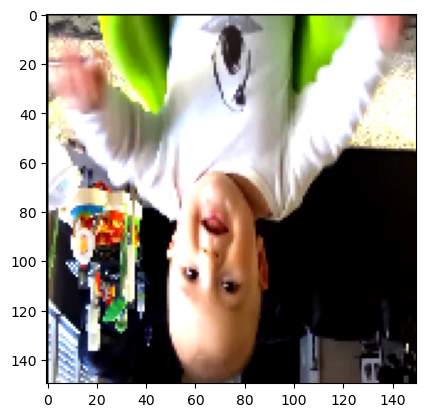

In [24]:
converted_images = np.clip(X_train_aug_2[2][1]*255, 0, 255).astype(np.uint8)
plt.imshow(converted_images)

In [25]:
X_train_aug_3,Y_train_aug_3 = data_augmentation_grayscale(X_train,Y_train)

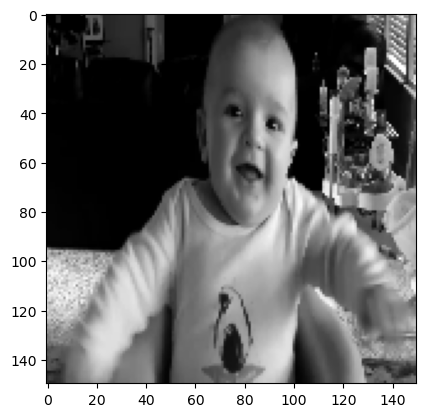

In [26]:
converted_images = np.clip(X_train_aug_3[2][1]*255, 0, 255).astype(np.uint8)
plt.imshow(converted_images)

IndexError: index 0 is out of bounds for axis 0 with size 0

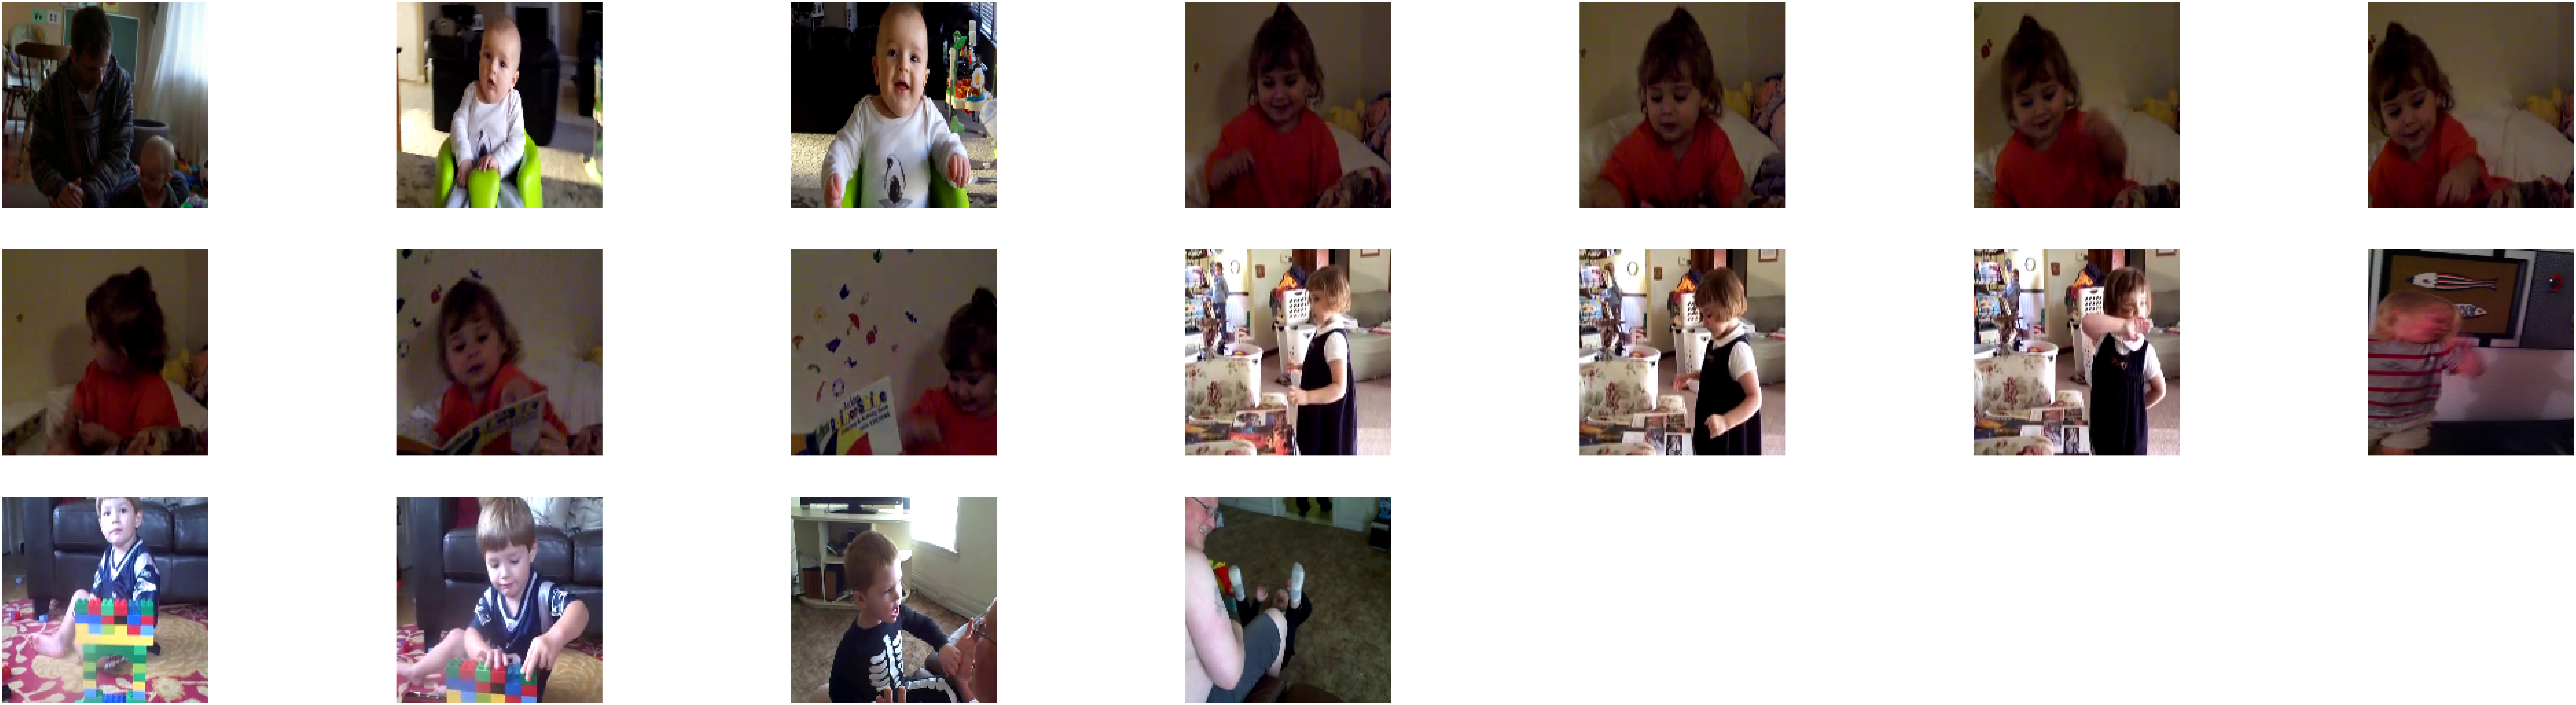

In [27]:
plt.figure(figsize=(150, 150))

for num, frame in enumerate(X_train):
    img = np.clip(frame[0]*255, 0, 255).astype(np.uint8)
    plt.subplot(11,7,num+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

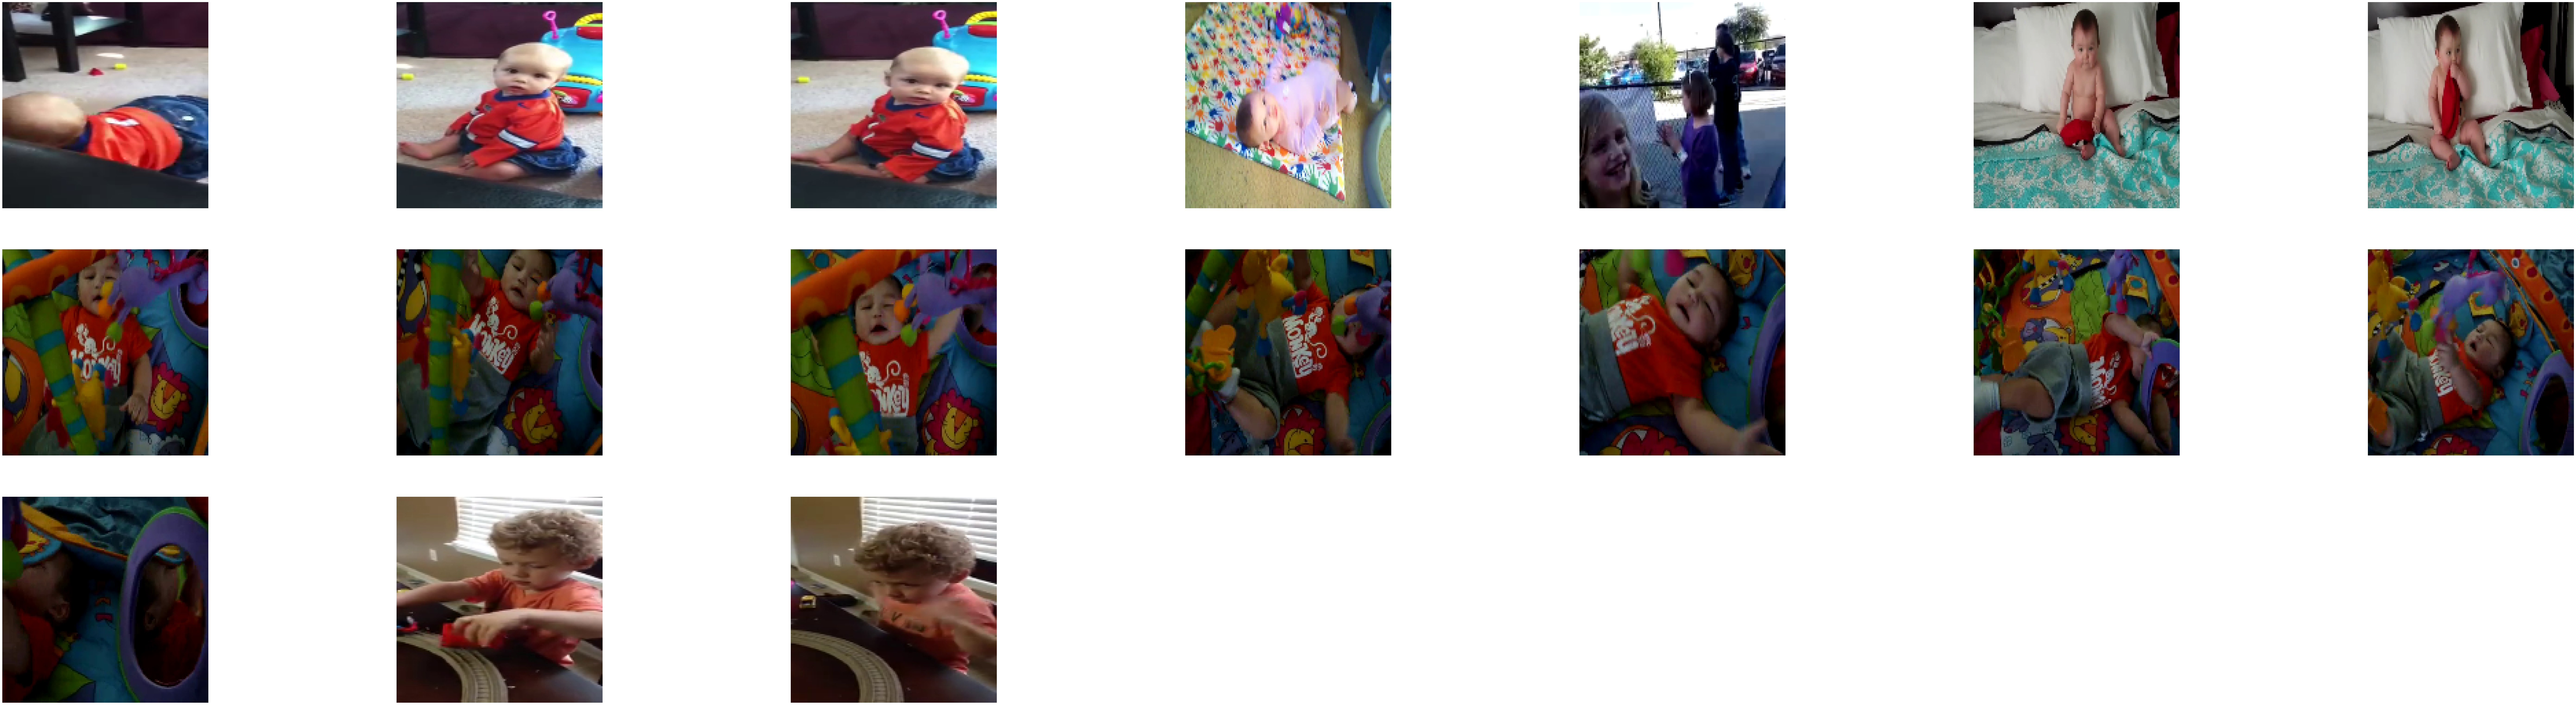

In [28]:
plt.figure(figsize=(150, 150))

for num, frame in enumerate(X_test):
    img = np.clip(frame[0]*255, 0, 255).astype(np.uint8)
    plt.subplot(11,7,num+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [29]:
len(X_train)

32

In [30]:
X_train_aug_1,Y_train_aug_1 = data_augmentation_flip_bright(X_train,Y_train)
X_train_aug_2,Y_train_aug_2 = data_augmentation_rotate_contrast(X_train,Y_train)
X_train_aug_3,Y_train_aug_3 = data_augmentation_grayscale(X_train,Y_train)

X_train_aug_1 = np.array([np.array(frame_list) for frame_list in X_train_aug_1])
X_train_aug_2 = np.array([np.array(frame_list) for frame_list in X_train_aug_2])

X_train_aug_3 = np.array([np.array(frame_list) for frame_list in X_train_aug_3])

X_train = np.append(X_train, X_train_aug_1, axis=0)
Y_train = np.append(Y_train, Y_train_aug_1, axis=0)
X_train = np.append(X_train, X_train_aug_2, axis=0)
Y_train = np.append(Y_train, Y_train_aug_2, axis=0)
X_train = np.append(X_train, X_train_aug_3, axis=0)
Y_train = np.append(Y_train, Y_train_aug_3, axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32,) + inhomogeneous part.

In [ ]:
X_train.shape

In [ ]:
Y_train.shape

In [ ]:
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def extract_features(frame_list):
    # This function should convert a list of frames into a fixed-length feature vector.
    # Placeholder: flattening the frames and taking the mean
    feature_vector = np.mean([frame.flatten() for frame in frame_list], axis=0)
    return feature_vector

In [ ]:
# Convert frames into feature vectors
X_train_features = np.array([extract_features(frames) for frames in X_train])
X_validate_features = np.array([extract_features(frames) for frames in X_validate])
X_test_features = np.array([extract_features(frames) for frames in X_test])

# Standardize the features (important for SVM)
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_validate_features = scaler.transform(X_validate_features)
X_test_features = scaler.transform(X_test_features)

In [ ]:
# Convert one-hot encoded labels to single labels
Y_train_labels = np.argmax(Y_train, axis=1)
Y_validate_labels = np.argmax(Y_validate, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

In [ ]:
# Initialize and train the classifier
clf = SVC(kernel='poly')  # You can change the kernel and other parameters
clf.fit(X_train_features, Y_train_labels)

# Validate the model
predictions = clf.predict(X_validate_features)
print(classification_report(Y_validate_labels, predictions))


In [ ]:
# Test the model
test_predictions = clf.predict(X_test_features)
print("Test Set Classification Report:")
print(classification_report(Y_test_labels, test_predictions))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test_labels, test_predictions))

In [ ]:
Y_test.shape

In [ ]:
print(predictions)

In [ ]:
print(Y_validate_labels)

In [ ]:
print(Y_test_labels)

In [ ]:
print(test_predictions)

In [ ]:
print(Y_test)

In [ ]:
print(Y_train_labels)

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def extract_features_from_video(path, start_time, end_time, movement_name):
    frames = extract_frame(path, start_time, end_time)  # Assuming this returns a list of frames
    sift = cv2.SIFT_create(contrastThreshold=0.04, edgeThreshold=10.0)  # Adjust SIFT parameters
    descriptors = []
    descriptions = []  # To store descriptions
    for frame in frames:
        # Convert tensor to numpy array if it's not already
        if isinstance(frame, tf.Tensor):
            frame = frame.numpy()
        
        # Resize the frame to a smaller resolution
        frame = cv2.resize(frame, (204, 360))  # Can adjust the resolution
        
        # Normalize frame intensity
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        
        gray_frame = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_RGB2GRAY)
        kp, des = sift.detectAndCompute(gray_frame, None)
        if des is not None:
            descriptors.extend(des)
            descriptions.extend([movement_name] * len(des))  # Replicate the movement name
    return np.array(descriptors), descriptions

In [ ]:
def load_data_and_extract_features(video_paths, start_times, end_times, labels):
    all_descriptors = []
    all_descriptions = []  # To store descriptions
    y_data = np.array(labels)  # Convert labels to a numpy array

    for i, path in enumerate(video_paths):
        movement_name = labels[i]  # Get the 'Movement_Name' from your dataset
        des, descriptions = extract_features_from_video(path, start_times[i], end_times[i], movement_name)
        if des.size > 0:
            all_descriptors.append(des)
            all_descriptions.extend(descriptions)  # Extend the descriptions list
    indices_to_delete = [i for i, des in enumerate(all_descriptors) if des.size == 0]

    # Assuming descriptor_size is known
    descriptor_size = all_descriptors[0].shape[1] if all_descriptors else None

    if descriptor_size is None:
        raise ValueError("No descriptors found in any of the videos")

    # Concatenate descriptors only if there are any
    if all_descriptors:
        descriptors_concatenated = np.vstack(all_descriptors)
    else:
        descriptors_concatenated = np.empty((0, descriptor_size))  # Empty array

    # Delete the labels and descriptions for videos with no descriptors
    y_data = np.delete(y_data, indices_to_delete)
    all_descriptions = [all_descriptions[i] for i in range(len(all_descriptions)) if i not in indices_to_delete]

    return descriptors_concatenated, y_data, all_descriptions

In [ ]:
import pandas as pd

def load_video_data():
    # Modify these paths and file names to match your dataset
    dataset_file_path = "C:/Users/hilma/Downloads/"
    dataset_filepath = dataset_file_path + "input_data/input_data_new.csv"
    df = pd.read_csv(dataset_filepath)

    # Assuming your DataFrame has columns 'File_Path', 'Start_Time', and 'End_Time', and 'Movement_Name'
    video_paths = df['File_Path'].apply(lambda x: dataset_file_path + x).tolist()
    start_times = df['Start_Time'].apply(convert_time_to_seconds).tolist()  # Assuming this function is already defined
    end_times = df['End_Time'].apply(convert_time_to_seconds).tolist()
    labels = df['Movement_Name'].tolist()  # Or however you wish to encode your labels

    return video_paths, start_times, end_times, labels


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans  # Import KMeans

def create_bag_of_words(descriptors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, n_init=5)  # Specify n_init here
    kmeans.fit(descriptors)
    return kmeans

In [ ]:
from collections import Counter

def generate_histogram(features, kmeans_model, num_clusters):
    labels = kmeans_model.predict(features)
    label_counts = Counter(labels)
    histogram = np.array([label_counts.get(i, 0) for i in range(num_clusters)])
    return histogram

In [ ]:
def videos_to_histograms(video_data, kmeans_model, num_clusters):  # Added num_clusters as a parameter
    histograms = []
    for path, start, end, label in video_data:
        features, _ = extract_features_from_video(path, start, end, label)
        histogram = generate_histogram(features, kmeans_model, num_clusters)  # Pass num_clusters here
        histograms.append(histogram)
    return histograms

In [ ]:
from sklearn.metrics import accuracy_score 

def main():
    print("Step 1: Loading video data...")
    video_paths, start_times, end_times, labels = load_video_data()  # Implement this according to the data
    print("Step 1 completed: Video data loaded.")
    
    # Extract features and labels
    print("Step 2: Extracting features and labels...")
    all_descriptors, y_data, all_descriptions = load_data_and_extract_features(video_paths, start_times, end_times, labels)
    print("Step 2 completed: Features and labels extracted.")
    
    # Create Bag of Words model with a fixed number of clusters
    num_clusters = 50  # Adjust as needed for specific task
    print(f"Step 3: Creating Bag of Words model with {num_clusters} clusters...")
    # Initialize the KMeans model with an explicit n_init value to suppress the warning
    kmeans_model = KMeans(n_clusters=num_clusters, n_init=10)
    # Fit the KMeans model on all descriptors
    kmeans_model.fit(np.vstack(all_descriptors))
    print("Step 3 completed: Bag of Words model created.")
    
    # Convert each video to a histogram of visual words
    print("Step 4: Converting videos to histograms of visual words...")
    X_histograms = [videos_to_histograms([(path, start, end, label)], kmeans_model, num_clusters)[0]  # Pass num_clusters here
                    for path, start, end, label in zip(video_paths, start_times, end_times, labels)]
    X_histograms = np.array(X_histograms)
    print("Step 4 completed: Videos converted to histograms.")
    
    # Standardize the features
    print("Step 5: Standardizing features...")
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_histograms)
    print("Step 5 completed: Features standardized.")

    # Split data into training and test sets
    print("Step 6: Splitting data into training and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(X_std, y_data, test_size=0.27, shuffle=False)
    print("Step 6 completed: Data split.")

    # Initialize and train the classifier
    print("Step 7: Initializing and training the classifier...")
    clf = SVC(kernel='poly', C=10)  # You can change the kernel and other parameters
    clf.fit(X_train, y_train)
    print("Step 7 completed: Classifier trained.")

    # Test the model
    print("Step 8: Testing the model...")
    test_predictions = clf.predict(X_test)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, test_predictions)
    print("Accuracy:", accuracy)
    # print("Test Set Classification Report:")
    # print(classification_report(y_test, test_predictions))

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, test_predictions))
    print("Step 8 completed: Model tested.")

if __name__ == "__main__":
    main()

